In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *

In [2]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
root_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw" #where the raw bdf files are
output_base = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed' #where all the preprocessed .mat files and other info go

plot = False
FS_ORIG = 2048  # Hz
#fs was 1024 for participant 03 and 2048 for participants 01 and 02
#subjects_to_process = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 
                     #  '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']  


In [3]:
#======================================================================================
#                       PREPROCESSING PARAMETERS
#======================================================================================
# Printing general info
print_info = False

# Notch filtering
notch_applied = True
freq_notch = 50

# Bandpass filtering
bpf_applied = True
freq_low   = 0.01
freq_high  = 15
bandpass = str(freq_low) + '-' + str(freq_high)
ftype = 'butter'
order = 3

# Spherical interpolation
int_applied = False
interpolation = 'spline'

# Rereferencing using average of mastoids electrodes
reref_applied = True
reref_type = 'Mastoids'  #Mastoids #Average

# Downsampling
down_applied = True
downfreq = 128
if not down_applied:
    downfreq = FS_ORIG
downfreq_factor =int(FS_ORIG/downfreq)

In [32]:
#load file

#file = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_02.bdf'
file = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_03.bdf'

raw = mne.io.read_raw_bdf(file, eog=None, misc=None, stim_channel='Status', 
                              infer_types=False, preload=True, verbose=None)

events = mne.find_events(raw, stim_channel='Status', shortest_event=1)
events_2, events_3, events_4, events_5, events_6, trial_starts = sort_events(events)

Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1248255  =      0.000 ...  1218.999 secs...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
106366 events found
Event IDs: [65282 65328 65535]
Some event types missing. Check data.


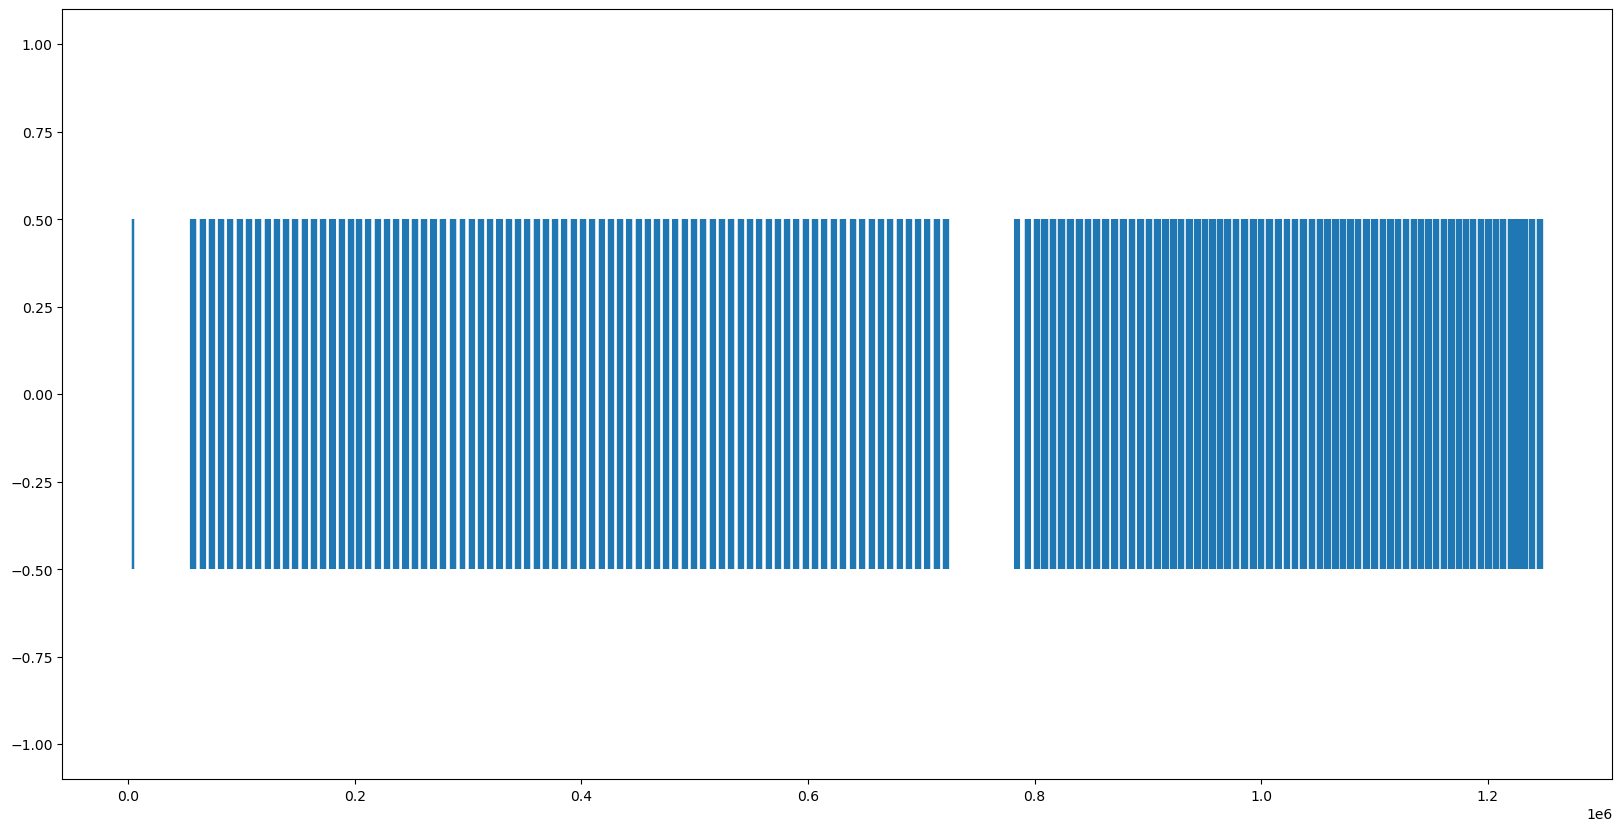

In [33]:
#check events

plot_subset = False
start = 0
end = 100


plt.figure(figsize = (20,10))

if plot_subset:
#keystrokes
    plt.eventplot(events_2[:,0][start:end], lineoffsets = 0)
    plt.eventplot(events_3[:,0][start:end], color = 'green', lineoffsets = -2)
    plt.eventplot(events_4[:,0][start:end], color = 'orange', lineoffsets = -3)
    plt.eventplot(events_5[:,0][start:end], color = 'red', lineoffsets=-4)
else:
    plt.eventplot(events_2[:,0], lineoffsets = 0)
    plt.eventplot(events_3[:,0], color = 'green', lineoffsets = -2)
    plt.eventplot(events_4[:,0], color = 'orange', lineoffsets = -3)
    plt.eventplot(events_5[:,0], color = 'red', lineoffsets=-4)

plt.show()

In [23]:
#Currently processing one subject at a time because many files are broken :(
#sub_folder = 'sub_03'
#files = sorted(glob.glob(os.path.join(root_dir, sub_folder, '**', '*.bdf'), recursive=True))

files = [ '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_04/sub_04.bdf']
period = 'pre'

for idx, file in enumerate(files):
    print(file)

    df_pre = pd.DataFrame()

    subject_ID = file.split('/')[-2][-2:]

    print("Currently processing ", file)
    #already_processed.append(subject_ID)

    output_dir = os.path.join(output_base, subject_ID)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    

    

    #======================================================================================
    #                        READ EEG FILES
    #======================================================================================

    raw = mne.io.read_raw_bdf(file, eog=None, misc=None, stim_channel='Status', 
                              infer_types=False, preload=True, verbose=None)


    # Check metadata
    n_time_samps = raw.n_times
    time_secs = raw.times
    ch_names = raw.ch_names
    n_chan = len(ch_names) 

    if print_info == True:
        print('the (cropped) sample data object has {} time samples and {} channels.'
            ''.format(n_time_samps, n_chan))
        print('The last time sample is at {} seconds.'.format(time_secs[-1]))
        print('The first few channel names are {}.'.format(', '.join(ch_names[:3])))
        print('bad channels:', raw.info['bads'])  # chs marked "bad" during acquisition
        print(raw.info['sfreq'], 'Hz')            # sampling frequency
        print(raw.info['description'], '\n')      # miscellaneous acquisition info
        print(raw.info)

    if plot:
        raw.plot(start=100, duration=10)


    #======================================================================================
    #                       FIND TRIGGERS FOR SEGMENTING
    #======================================================================================
    #loading the raw events
    #the stim channel is called 'Status' 
    events = mne.find_events(raw, stim_channel='Status', shortest_event=1) #raises exception if shortest event is default 2...?
    

#...TO DO: import bad triggers noted in experiment from corresponding csv 
    bad_triggers = []
    #events.pop(bad_triggers indices)

    #cleaned triggers according to channel
    #trial start and end are indicated in channel 5, filtered for 10+ min duration
    events_2, events_3, events_4, events_5, events_6, trial_starts = sort_events(events)
    #_, _, _, _, _, trial_starts = sort_events(events)


   
    #======================================================================================
    #                        CROPPING FILES TO THE TRIAL
    #======================================================================================
    print("trial starts: \n", trial_starts)
    
    #trial durations
    listen_dur = 665
    motor_dur = 600
    error_dur = 600

    #start times for cropping
    #listen_pre_start, motor_pre_start, error_pre_start, listen_post_start, motor_post_start, error_post_start = trial_starts[:,0]/FS_ORIG
    #listen_pre_start, motor_pre_start, error_pre_start = trial_starts[:,0]/FS_ORIG
    listen_pre_start, motor_pre_start = trial_starts[:,0]/FS_ORIG

    #end times
    listen_pre_end = listen_pre_start+listen_dur
    motor_pre_end = motor_pre_start+motor_dur
    motor_pre_end = motor_pre_start + 580
    #error_pre_end = error_pre_start+error_dur
   # error_pre_end = error_pre_start + 440
    """
    listen_post_end = listen_post_start+listen_dur
    motor_post_end = motor_post_start+motor_dur
    error_post_end = error_post_start+error_dur"""
   
    

#.....TO DO
    #add stuff for post 
    #approximate crop for training?
    eeg_listen_pre = raw.copy().crop(tmin = listen_pre_start, tmax = listen_pre_end)
    eeg_motor_pre = raw.copy().crop(tmin = motor_pre_start, tmax = motor_pre_end)
    #eeg_error_pre = raw.copy().crop(tmin = error_pre_start, tmax = error_pre_end)

    """
    
    eeg_listen_post = raw.copy().crop(tmin = listen_post_start, tmax = listen_post_end)
    eeg_motor_post = raw.copy().crop(tmin = motor_post_start, tmax = motor_post_end)
    eeg_error_post = raw.copy().crop(tmin = error_post_start, tmax = error_post_end)    """

  

    #------------------------   
    # CHOOSING FILES TO PROCESS
    #---------------------------

    #get the eeg data
    #eegs_to_process = [eeg_listen_pre, eeg_motor_pre, eeg_error_pre, eeg_listen_post, eeg_motor_post, eeg_error_post]
    eegs_to_process = [eeg_listen_pre, eeg_motor_pre]

   

    if period == 'pre':
        eeg_names = ['eeg_listen_pre', 'eeg_motor_pre', 'eeg_error_pre']
    elif period == 'post':
        eeg_names = ['eeg_listen_post', 'eeg_motor_post', 'eeg_error_post']
     #eeg_names = ['eeg_listen_pre', 'eeg_motor_pre', 'eeg_error_pre', 'eeg_listen_post', 'eeg_motor_post', 'eeg_error_post']
    
  
    eeg_names = ['eeg_listen_pre', 'eeg_motor_pre']

    #======================================================================================
    #                       FILTERING
    #======================================================================================
    for i, data in enumerate(eegs_to_process):
        ## -------------
        ## Select channels
        ## -------------

        #eeg_channels = ch_names[:66] + [ch_names[-1]]
        eeg_channels = ch_names[0:72]
        eeg = data.copy().pick_channels(eeg_channels)
        if plot:
            eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))

        
        """eeg_channels = ch_names[0:66]
        eeg = eeg.pick_channels(eeg_channels)
        if plot:
            eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))"""
        
        ## -------------
        ## Notch filtering
        ## -------------
        df_pre['notch_applied'] = [notch_applied]
        if notch_applied:
            eeg = eeg.notch_filter(freqs=freq_notch)
            df_pre['notch'] = [freq_notch]
            if plot:
                eeg.plot()
  
        ## -------------
        ## BPFiltering
        ## -------------
        df_pre['bpf_applied'] = [bpf_applied]
        if bpf_applied:
            iir_params = dict(order=order, ftype=ftype)
            filter_params = mne.filter.create_filter(eeg.get_data(), eeg.info['sfreq'], 
                                                    l_freq=freq_low, h_freq=freq_high, 
                                                    method='iir', iir_params=iir_params)

            if plot:
                flim = (1., eeg.info['sfreq'] / 2.)  # frequencies
                dlim = (-0.001, 0.001)  # delays
                kwargs = dict(flim=flim, dlim=dlim)
                mne.viz.plot_filter(filter_params, eeg.info['sfreq'], compensate=True, **kwargs)
                # plt.savefig(os.path.join(output_dir, 'bpf_ffilt_shape.png'))

            eeg = eeg.filter(l_freq=freq_low, h_freq=freq_high, method='iir', iir_params=iir_params)
            df_pre['bandpass'] = [iir_params]
            df_pre['HPF'] = [freq_low]
            df_pre['LPF'] = [freq_high]
            if plot:
                eeg.plot()

         
         #...interpolation
                
            
        ## -------------
        ## Rereferencing
        ## -------------
        df_pre['reref_applied'] = [reref_applied]
        if reref_applied:
            # Set electrodes for rereferencing
            if reref_type == 'Mastoids':
                reref_channels = ['EXG1', 'EXG2']
                """try:
                    reref_channels = ['M1', 'M2']   
                except ValueError as e:
                    print("Mastoid channel names not changed:", e)
                    reref_channels = ['EXG1', 'EXG2']  """
            else:
                reref_channels = 'average'           

            # Actually r-referencing signals
            eeg = eeg.set_eeg_reference(ref_channels=reref_channels)
            df_pre['reref_type'] = [reref_type]
            df_pre['reref_channels'] = [reref_channels]
            if plot:
                eeg.plot()

         
        ## -------------
        ## Downsampling
        ## -------------
        df_pre['down_applied'] = [down_applied]
        df_pre['downfreq'] = [downfreq]
        if down_applied:
            eeg = eeg.resample(sfreq=downfreq)
            if plot:
                eeg.plot()
  

    #======================================================================================
    #                      UPDATE TRIGGERS
    #======================================================================================
      
        #create support vectors
        #zero array with downsampled dimensions
        events_original = np.zeros((5, data.get_data().shape[1])) #5 rows = event types, along time axis zero when there is an event and 1 everywhere else
        
      
        #get triggers
        section_triggers = mne.find_events(data, stim_channel='Status', shortest_event=1)
        events_2, events_3, events_4, events_5, events_6, section_start = sort_events(section_triggers, clean = True)

        #get trial start time
        section_start = section_start[0][0]
        
        #find indices corrected for start time
        indices_2 = (events_2[:,0]) - section_start
        indices_3 = (events_3[:,0]) - section_start
        indices_4 = (events_4[:,0]) - section_start
        indices_5 = (events_5[:,0]) - section_start   

        #populate event array with 1s where there are events
        
        events_original[0][indices_2] = 1
        events_original[1][indices_3] = 1
        events_original[2][indices_4] = 1
        events_original[3][indices_5] = 1

        #resample while preserving events
        cropped_length = eeg.get_data().shape[1]
        events_resampled = np.zeros((5, cropped_length))
        for row in range(events_resampled.shape[0]):
            events_resampled[row] = discretize(events_original[row], final_length = cropped_length, downfreq_factor = downfreq_factor)

    #======================================================================================
    #                       SAVING CROPPED FILES
    #======================================================================================
        
        name = eeg_names[i]
        eeg_tosave = eeg.get_data()

        savemat(os.path.join(output_dir,   f'{name}_{subject_ID}.mat'), {'trial_data': eeg_tosave[0:64, :], 'trial_mastoids': eeg_tosave[64:66, :], 'trial_exg': eeg_tosave[66:72, :], 'events': events_resampled})
    

         ## -------------
        ## Save preprocessing stages
        ## -------------
    df_pre.to_csv(os.path.join(output_dir, f"preprocess_record_{subject_ID}.csv"), index=False)


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_04/sub_04.bdf
Currently processing  /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_04/sub_04.bdf
Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_04/sub_04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3059711  =      0.000 ...  1494.000 secs...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
159013 events found
Event IDs: [65282 65296]
All event types present
trial starts: 
 [[  95370   65280   65296]
 [1865570   65280   65296]]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s


Setting up band-pass filter from 0.01 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 15.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
59325 events found
Event IDs: [65282 65296]
All event types present
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-stop filte

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Setting up band-pass filter from 0.01 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 0.01, 15.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
98623 events found
Event IDs: [65282 65296]
All event types present


In [19]:
trial_starts

array([[  95370,   65280,   65296],
       [1865570,   65280,   65296]])

In [72]:
a, b, c = events_5[:,0][[0,2, 4]]

In [ ]:
ch_names

['Fp1',
 'AF7',
 'AF3',
 'F1',
 'F3',
 'F5',
 'F7',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'C1',
 'C3',
 'C5',
 'T7',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'P1',
 'P3',
 'P5',
 'P7',
 'P9',
 'PO7',
 'PO3',
 'O1',
 'Iz',
 'Oz',
 'POz',
 'Pz',
 'CPz',
 'Fpz',
 'Fp2',
 'AF8',
 'AF4',
 'AFz',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT8',
 'FC6',
 'FC4',
 'FC2',
 'FCz',
 'Cz',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP8',
 'CP6',
 'CP4',
 'CP2',
 'P2',
 'P4',
 'P6',
 'P8',
 'P10',
 'PO8',
 'PO4',
 'O2',
 'EXG1',
 'EXG2',
 'EXG3',
 'EXG4',
 'EXG5',
 'EXG6',
 'EXG7',
 'EXG8',
 'Status']

In [ ]:
events_6

array([[  65361,   65280,   65328],
       [1427257,   65280,   65328],
       [1768381,   65280,   65328],
       [2195456,   65280,   65535],
       [2201600,   65280,   65535]])

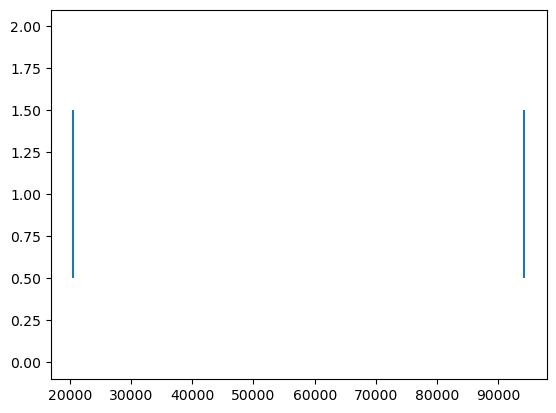

In [ ]:
plt.eventplot(events_6[:,0])

In [ ]:
error_pre_end

1457.9404296875

In [ ]:
events_6

array([[  65361,   65280,   65328],
       [1427257,   65280,   65328],
       [1768381,   65280,   65328],
       [2195456,   65280,   65535],
       [2201600,   65280,   65535]])

In [ ]:
events_6[[0, 2, 3]]

array([[  65361,   65280,   65328],
       [1768381,   65280,   65328],
       [2195456,   65280,   65535]])

In [ ]:
error_pre_start

857.9404296875

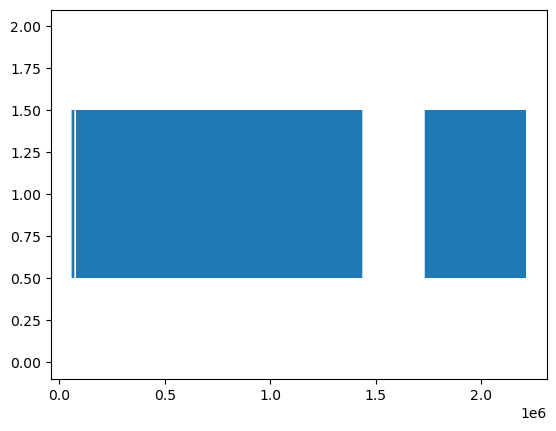

In [ ]:
plt.eventplot(events[:,0])

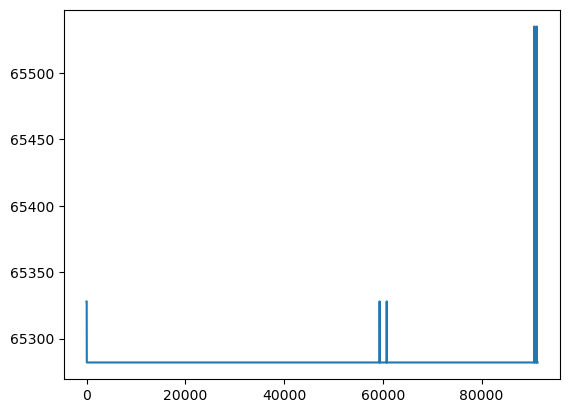

In [ ]:
plt.plot(events[:,2])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(events_original[2])

NameError: name 'events_original' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(events_resampled[2])

NameError: name 'events_resampled' is not defined

<Figure size 2000x1000 with 0 Axes>

## EXPLORATION BELOW, NOT FOR THE ACTUAL PIPELINE
Note the different thresholds used (keystroke triggers are longer than mode switch or trial triggers)

In [ ]:
trial_starts

array([[ 332604,   65280,   65296],
       [2072464,   65280,   65296],
       [3681072,   65280,   65296],
       [6102881,   65280,   65296],
       [7850577,   65280,   65296],
       [9370825,   65280,   65296]])

In [ ]:
"""raw_events = mne.find_events(raw, shortest_event=1)
raw.plot(events = raw_events)"""

'raw_events = mne.find_events(raw, shortest_event=1)\nraw.plot(events = raw_events)'

In [ ]:
listen_events_pre = clean_triggers(mne.find_events(eeg_listen_pre), threshold=1200)
eeg_listen_pre.plot(events = listen_events_pre)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
59401 events found
Event IDs: [65282 65296]
Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
motor_events_pre = clean_triggers(mne.find_events(eeg_motor_pre), threshold=1500)
eeg_motor_pre.plot(events = motor_events_pre)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
65802 events found
Event IDs: [65282 65296]
Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
error_events_pre = clean_triggers(mne.find_events(eeg_error_pre, shortest_event=1), threshold=1500)
eeg_error_pre.plot(events = error_events_pre)

Trigger channel has a non-zero initial value of 65328 (consider using initial_event=True to detect this event)
47685 events found
Event IDs: [65282 65328 65330]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
listen_events_post =clean_triggers(mne.find_events(eeg_listen_post), threshold=1200)
eeg_listen_post.plot(events = listen_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
59326 events found
Event IDs: [65282 65296]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
motor_events_post =clean_triggers(mne.find_events(eeg_motor_post, shortest_event = 1), threshold=1200)
eeg_motor_post.plot(events = motor_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
69217 events found
Event IDs: [65282 65296 65298]
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [ ]:
error_events_post =clean_triggers(mne.find_events(eeg_error_post, shortest_event = 1), threshold=1200)
eeg_error_post.plot(events = error_events_post)

Trigger channel has a non-zero initial value of 65296 (consider using initial_event=True to detect this event)
46522 events found
Event IDs: [65282 65284 65286 65288 65290 65296 65298]


Using pyopengl with version 3.1.6


Channels marked as bad:
none
